# Graph Evolution

Graph evolution for given algorithms and dataset.

In [1]:
import os
import random
import time
import numpy as np
import networkx as nx

# local imports
import graph_evolution_metrics as metrics

# Seed for reproducibility
random.seed(42)

In [2]:
## CHANGE TO MATCH ALG AND DATASET

# Module of alg being used
import personalized_pagerank as alg
import random_removal_per_node as rm

# Name of dataset being used
# Directed: wiki_vote, congress, email_eu
# Undirected: facebook, deezer, lastfm

# BASENAME, DIRECTED = "congress", True
BASENAME, DIRECTED = "email_eu", True
# BASENAME, DIRECTED = "wiki_vote", True
# BASENAME, DIRECTED = "facebook", False
# BASENAME, DIRECTED = "lastfm", False
# BASENAME, DIRECTED = "deezer", False


In [3]:
## PARAMS

# Graph Evolution
ITERATIONS = 30

In [4]:
# Constants for I/O
INPUT_DIR = "../input"
OUTPUT_DIR = "../data"

OUTPUT_PREFIX = BASENAME + "." + alg.__name__

CLUSTERING_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".clu")
GINI_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".gin")
VISIBILITY_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".vis")
SUMMARY_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".sum")
PLOT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".png")

EDGELIST = BASENAME + ".txt"
MINORITIES = BASENAME + ".minorities"
EDGELIST_PATH = os.path.join(INPUT_DIR, EDGELIST)
MINORITIES_PATH = os.path.join(INPUT_DIR, MINORITIES)

In [5]:
init_g = nx.read_edgelist(EDGELIST_PATH, create_using=nx.DiGraph(), nodetype=int)

if not DIRECTED:
    # keep as DiGraph but add edges in opposite direction
    init_g.add_edges_from([(v, u) for u, v in init_g.edges()])

## Network Evolution Following Wagner's Methods

In [6]:
def add_edges(nx_g, edges):
    """
    Adds edges to given graph.
    """
    nx_g.add_edges_from(edges)
    if not DIRECTED:
        nx_g.add_edges_from([(v, u) for (u, v) in edges])


def remove_edges(nx_g, edges):
    """
    Removes edges from given graph.
    """
    nx_g.remove_edges_from(edges)
    if not DIRECTED:
        nx_g.remove_edges_from([(v, u) for (u, v) in edges])

    
# IMPORTANT: we do deletions to keep a baseline for the clustering coefficient and 
# see the effect of the algorithm on the graphs structure
def evolve_network(nx_g, minorities):
    """
    Iteratively evolve the network by adding and removing edges.
    """
    # initial metrics
    ginis = [metrics.gini_of_degree_distribution(nx_g)]
    clusters = [nx.average_clustering(nx_g)]
    visibilities = [metrics.pagerank_visibility(nx_g, minorities)]

    # prepare for algorithm
    nx_g = alg.initialize(nx_g, directed=DIRECTED)

    print("Iteration")
    print(f"0: {nx_g}")

    for i in range(1, ITERATIONS+1):

        predictions = alg.predict(nx_g, directed=DIRECTED)
        add_edges(nx_g, predictions)

        removals = rm.removals(nx_g, directed=DIRECTED)
        remove_edges(nx_g, removals)

        # compute metrics
        ginis.append(metrics.gini_of_degree_distribution(nx_g))
        clusters.append(metrics.average_clustering(nx_g))
        visibilities.append(metrics.pagerank_visibility(nx_g, minorities))
  
        if i % 2 == 0:
            print(f"{i}: {nx_g}")
    
    return ginis, clusters, visibilities

In [7]:
minorities = []
with open(MINORITIES_PATH, "r") as f:
    for line in f:
        node = int(line.strip())
        minorities.append(node)

print(f"Minority size: {len(minorities)}")

Minority size: 151


In [8]:
# evolve the network
start = time.time()
ginis, clusters, visibilities = evolve_network(init_g, minorities)
end = time.time()
print(f"Time elapsed: {end - start}")

Iteration
0: DiGraph with 1005 nodes and 25571 edges
2: DiGraph with 1005 nodes and 25708 edges
4: DiGraph with 1005 nodes and 25708 edges
6: DiGraph with 1005 nodes and 25708 edges
8: DiGraph with 1005 nodes and 25708 edges
10: DiGraph with 1005 nodes and 25708 edges
12: DiGraph with 1005 nodes and 25708 edges
14: DiGraph with 1005 nodes and 25708 edges
16: DiGraph with 1005 nodes and 25708 edges
18: DiGraph with 1005 nodes and 25708 edges
20: DiGraph with 1005 nodes and 25708 edges
22: DiGraph with 1005 nodes and 25708 edges
24: DiGraph with 1005 nodes and 25708 edges
26: DiGraph with 1005 nodes and 25708 edges
28: DiGraph with 1005 nodes and 25708 edges
30: DiGraph with 1005 nodes and 25708 edges
Time elapsed: 1568.6776957511902


## Write to Files

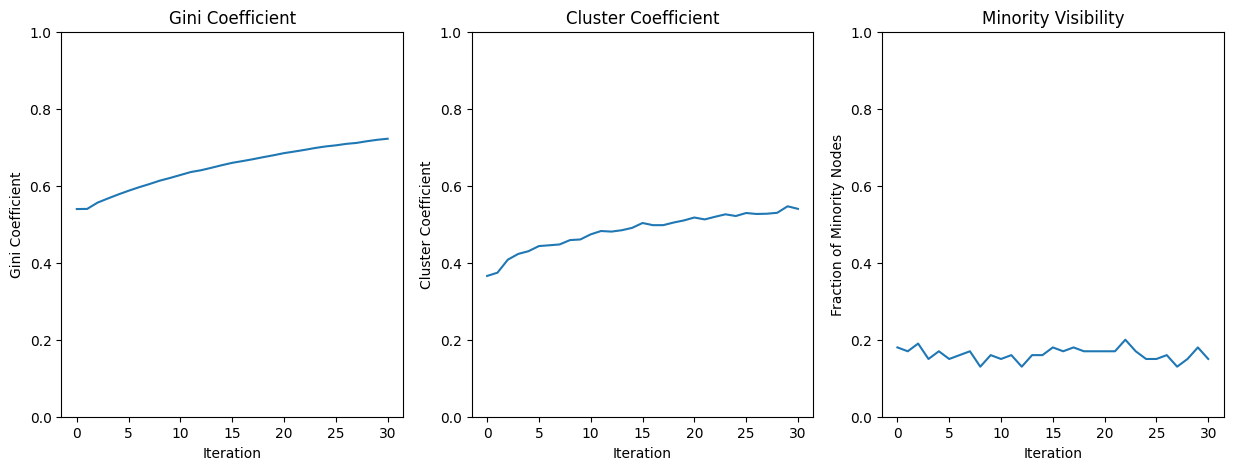

In [9]:
# plot data
metrics.plot_to_file(PLOT_PATH, ginis, clusters, visibilities)

In [10]:
# write gini_coefficient to file
metrics.list_to_file(GINI_PATH, ginis)

In [11]:
# write gini_coefficient to file
metrics.list_to_file(CLUSTERING_PATH, clusters)

In [12]:
# write visibilities to file
metrics.list_to_file(VISIBILITY_PATH, visibilities)

In [13]:
with open(SUMMARY_PATH, 'w') as f:
    f.write(f"Iterations: {ITERATIONS}\n")
    f.write(f"Removals: {rm.__name__}\n")
    f.write(f"Predictions: {alg.__name__}\n")
    f.write(f"Total number of nodes: {init_g.number_of_nodes()}\n")
    f.write(f"Minority size: {len(minorities)}\n")